# Introduction To Machine Learning: PCA
In this notebook, we shall use the usps dataset and differentiate between the grayscale digits 1 and 5

# Imports

In [12]:
# the warning wrapper is to avoid an annoying warning of h5py
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import h5py
warnings.resetwarnings()
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from functools import reduce
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

### Load the usps dataset
Grayscale 16x16 digits.
already scaled to 0-1 range (instead of 0-255).

In [13]:
def hdf5(path, data_key = "data", target_key = "target", flatten = True):
    """
        loads data from hdf5:
        - hdf5 should have 'train' and 'test' groups
        - each group should have 'data' and 'target' dataset or spcify the key
        - flatten means to flatten images N * (C * H * W) as N * D array
    """
    with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        X_train = train.get(data_key)[:]
        y_train = train.get(target_key)[:]
        test = hf.get('test')
        X_test = test.get(data_key)[:]
        y_test = test.get(target_key)[:]
        if flatten:
            X_train = X_train.reshape(X_train.shape[0], reduce(lambda a, b: a * b, X_train.shape[1:]))
            X_test = X_test.reshape(X_test.shape[0], reduce(lambda a, b: a * b, X_test.shape[1:]))
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = hdf5("usps.h5")
print("Dataset loaded. Train shape: "+str(X_train.shape)+". Test shape: "+str(X_test.shape)+".")

Dataset loaded. Train shape: (7291, 256). Test shape: (2007, 256).


### View some samples

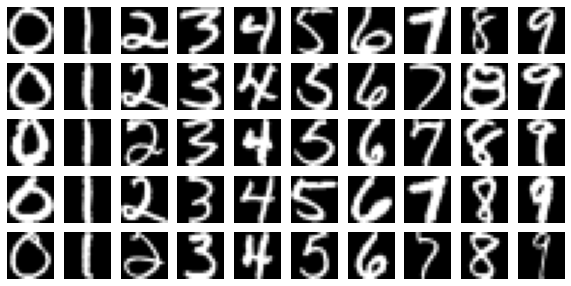

In [14]:
num_samples = 5
num_classes = len(set(y_train))

classes = set(y_train)
num_classes = len(classes)
fig, ax = plt.subplots(num_samples, num_classes, sharex = True, sharey = True, figsize=(num_classes, num_samples))

for label in range(num_classes):
    class_idxs = np.where(y_train == label)
    for i, idx in enumerate(np.random.randint(0, class_idxs[0].shape[0], num_samples)):
        # the imshow with 'gray' option, recieves either 0-255 integers, or 0-1 floats.
        ax[i, label].imshow(X_train[class_idxs[0][idx]].reshape([16, 16]), 'gray')
        ax[i, label].set_axis_off()
plt.show()

## View reconstructed digits with respect to number of eigenvectors

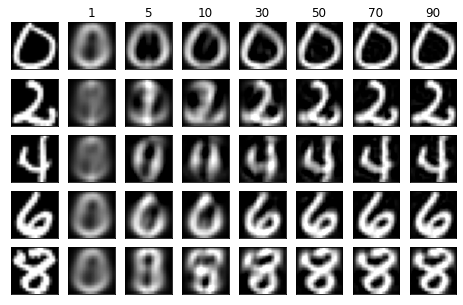

In [15]:
# define number of vectors
components = [1, 5, 10, 30, 50, 70, 90]
digit_indices = [np.argmax(y_train == digit) for digit in [0,2,4,6,8]] #you may choose any other digits.

rows, columns = len(digit_indices), len(components)+1 #the +1 is to include the original image also
result = np.zeros((rows,columns,256)) #(rows, columns, pixels)
result[:,0,:] = X_train[digit_indices,:] #first column

#create result array
for i, n_components in enumerate(components):
    pca = PCA(n_components = n_components, whiten=True)
    X_reduced = pca.fit_transform(X_train)
    X_reconstructed = pca.inverse_transform(X_reduced)
    result[:,i+1,:] = X_reconstructed[digit_indices,:]
    
#plot
result = result.reshape((rows*columns,16,16))
fig, ax = plt.subplots(rows, columns, figsize=(columns, rows), subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    if 0<i<columns:
        axi.set_title(str(components[i-1]))
    im = axi.imshow(result[i], cmap='gray')
    im.set_clim(0,1)

## View principal components

<Figure size 576x864 with 0 Axes>

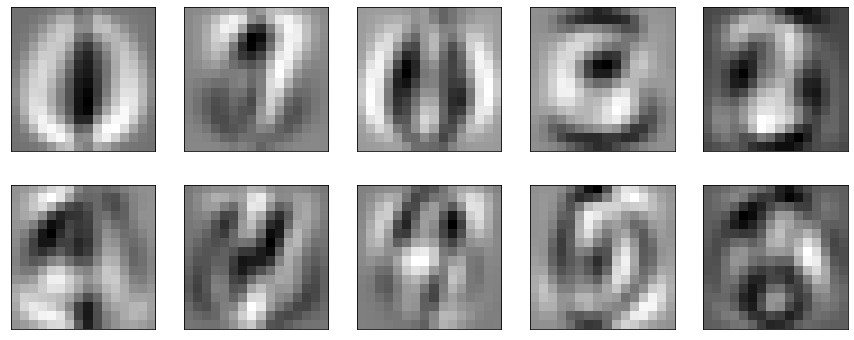

In [16]:
# define number of vectors
components = 10

rows, columns = 2, (components+1)//2 #the +1 is to include the original image also
pca = PCA(n_components = n_components, whiten=True)
pca.fit(X_train)

#rescale the components for visualizations (they currently have values around 0. even negative)
scaled_components = pca.components_ - np.expand_dims(pca.components_.min(axis=1),1)
scaled_components /= np.expand_dims(scaled_components.max(axis=1),1)

#plot
figure = plt.figure(figsize=(8,12))
fig, ax = plt.subplots(rows, columns, figsize=((15, 6)), subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    im = axi.imshow(scaled_components[i].reshape((16,16)), cmap='gray')
    im.set_clim(0,1)

# Plot variance with respect to number of eigenvectors

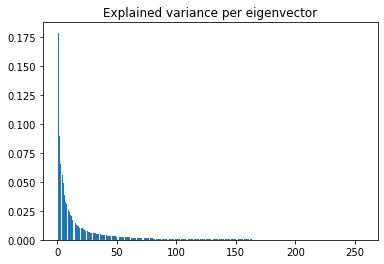

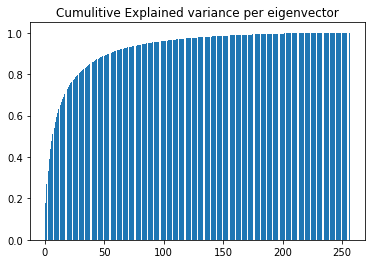

For explained variance: 0.95 number of dimensions: 88
For explained variance: 0.99 number of dimensions: 169


In [17]:
pca = PCA(n_components = X_train.shape[1], whiten=True)
pca.fit_transform(X_train)
plt.bar(range(1, len(pca.explained_variance_ratio_)+1),pca.explained_variance_ratio_)
plt.title("Explained variance per eigenvector")
plt.show()
plt.bar(range(1, len(pca.explained_variance_ratio_)+1),np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulitive Explained variance per eigenvector")
plt.show()
for variance in [0.95, 0.99]:
    pca = PCA(variance, whiten=True)
    data = pca.fit_transform(X_train.data)
    print("For explained variance:", variance, "number of dimensions:", data.shape[1])

# Taking 5 and 1 digits only

In [18]:
X_train_1 = X_train[y_train == 1]
X_train_5 = X_train[y_train == 5]
X_train_1_5 = np.concatenate((X_train_1, X_train_5))
delimiter = X_train_1.shape[0] # delimits between 1's and 5's

In [19]:
X_train_1.shape, X_train_5.shape, X_train_1_5.shape

((1005, 256), (556, 256), (1561, 256))

In [20]:
pca = PCA(n_components = 2, whiten=True)
X_1_5_reduced = pca.fit_transform(X_train_1_5)

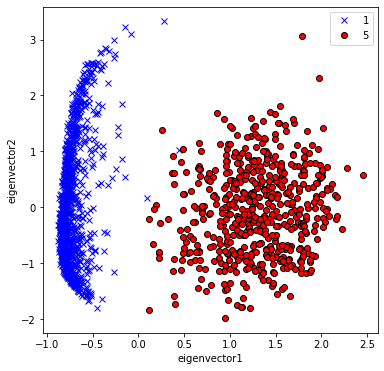

In [21]:
plt.figure(figsize=(6,6))
plt.plot([im[0] for im in X_1_5_reduced[:delimiter]],[im[1] for im in X_1_5_reduced[:delimiter]],'bx',label='1')
plt.plot([im[0] for im in X_1_5_reduced[delimiter:]],[im[1] for im in X_1_5_reduced[delimiter:]],'ro',label='5', markeredgecolor='black')
plt.xlabel("eigenvector1")
plt.ylabel("eigenvector2")
plt.legend(numpoints=1)
plt.show()

### Which components did we learn?

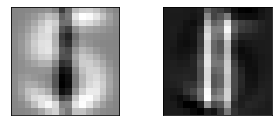

In [22]:
components = pca.components_
scaled_components = pca.components_ - np.expand_dims(pca.components_.min(axis=1),1)
scaled_components /= np.expand_dims(scaled_components.max(axis=1),1)

fig, ax = plt.subplots(1, 2, figsize=(columns, rows), subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    im = axi.imshow(scaled_components[i].reshape((16,16)), cmap='gray')
    im.set_clim(0,1)

### Lets look at the "outlier" (the right most '1')

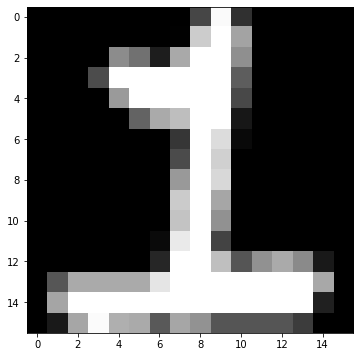

In [23]:
plt.figure(figsize=(6,6))
idx = np.argmax([im[0] for im in X_1_5_reduced[:delimiter]])
plt.imshow(X_train_1_5[idx].reshape((16,16)), cmap='gray')

## Comparison with the "manual preprocessing we did on lecture 2"

Done preprocessing. New shape:  (1561, 2)


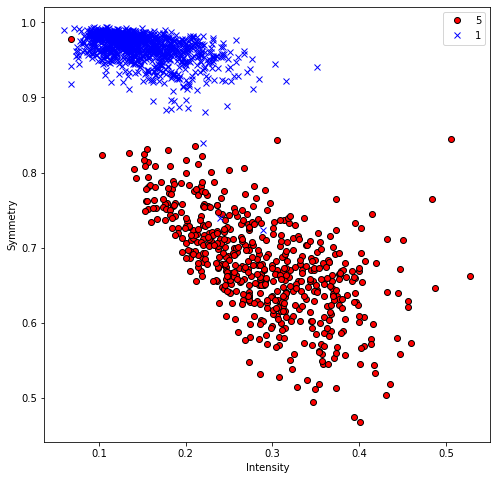

In [24]:
def symmetry(image):
    im = image.reshape((16,16))
    return np.mean(1-np.abs(im - im[::-1,:]))
def intensity(image):
    return np.mean(image)

def phi(image):
    #nonlinear transformation
    return np.array([intensity(image),symmetry(image)])

# apply phi on all the dataset
X_1_5_pro = np.array([phi(im) for im in X_train_1_5])
X_pro_1, X_pro_5 = X_1_5_pro[:delimiter], X_1_5_pro[delimiter:]
print('Done preprocessing. New shape: ', X_1_5_pro.shape)

# plot
plt.figure(figsize=(8,8))
plt.plot([im[0] for im in X_pro_5],[im[1] for im in X_pro_5],'ro',label='5', markeredgecolor='black', markeredgewidth=1)
plt.plot([im[0] for im in X_pro_1],[im[1] for im in X_pro_1],'bx',label='1')
plt.xlabel('Intensity')
plt.ylabel('Symmetry')
plt.legend(numpoints=1)
plt.show()

Keep in mind that thought the PCA split looks a bit better, it lacks intuitive\business information regarding its features